In [1]:
!python --version

Python 3.13.4


In [1]:
import gc
from PIL import Image

import torch
import torchvision
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

In [2]:
# what does a convolution kernel do to an image???

image = np.array(Image.open(r"../cowpea/91.TIF"))
height, width, _ = image.shape

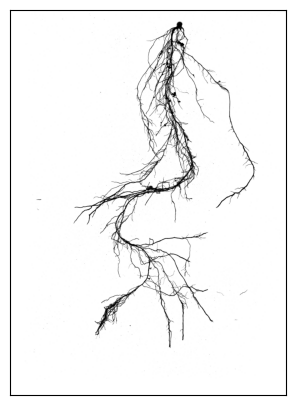

In [3]:
fig, axes = plt.subplots()
fig.set_size_inches(5, 5)
axes.imshow(image)
axes.set_xticks([])
axes.set_yticks([])
plt.show()

In [12]:
def rgb_matrix_to_tensor(image: NDArray[np.uint8]) -> torch.FloatTensor:
    """
    input is expected to be a H x W matrix made of [R, G, B] channels
    i.e of shape (H, W, 3)
    """

    height, width, nchannels = image.shape
    if nchannels != 3: # RGB channels expected!!!
        raise RuntimeError(f"Only images using the standard RGB channel pixels are supported! Expected 3 channels, but got {nchannels} channels!")
    
    result = torch.tensor(np.array(np.unstack(image, axis=-1)), # split the image into 3 matrixes for each R, G and B channels
                       dtype=torch.float32)
    
    assert (result.shape[0] == 3) and (result.shape[1] == height) and (result.shape[2] == width), "Shape mismatches between input array and result tensor!"
    return result

def tensor_to_rgb_channels(tensor: torch.FloatTensor) -> torch.FloatTensor:
    return np.stack(tensor, axis=-1)

In [13]:
with torch.no_grad():
    convolved = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(10, 10))(rgb_matrix_to_tensor(image))

In [21]:
def scale_to_standard_rgb_channels(tensor: torch.FloatTensor|NDArray[np.floating]) -> torch.FloatTensor:
    """
    
    """
    tensor += abs(tensor.min()) # probably a negative value, hence the abs()
    tensor /= tensor.max() # downscale to (0.00, 1.00)
    tensor *= 255 # upscale to RGB channel max 255
    return tensor.type(torch.uint8) if isinstance(tensor, torch.FloatTensor) else tensor.astype(np.uint8)

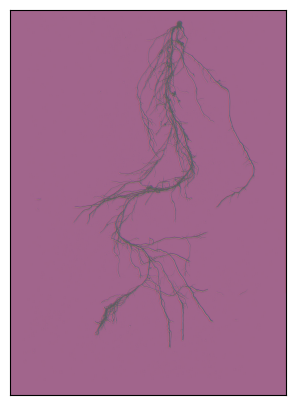

In [25]:
fig, axes = plt.subplots()
fig.set_size_inches(5, 5)
axes.imshow(scale_to_standard_rgb_channels(tensor_to_rgb_channels(convolved)), cmap="binary")
axes.set_xticks([])
axes.set_yticks([])
plt.show()